## A first try to Branch and Bound algorithm for the 0/1 Knapsack Problem

Implementation inspired by the following tutorial by Abdul Bari: https://www.youtube.com/watch?v=yV1d-b_NeK8

In [1]:
# Instance
# State Space Tree
# Breadth First Search
# done

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as random
import time as time
import seaborn as sns

from matplotlib.lines import Line2D

In [3]:
#no_of_items = 10
def knpsck_generator(no_of_items):
    weights = [random.randint(5,20) for x in range(0,no_of_items)]
    profits = [random.randint(1,25) for x in range(0,no_of_items)]
    p_per_w = [p/w for p,w in zip(profits,weights)]
    
    instance = [[pw,[p,w]] for pw,p,w in zip(p_per_w, profits, weights)]
    # Sorted items:
    instance = sorted(instance, reverse=True)
    instance = [[e,x[0],x[1][0],x[1][1]] for e,x in enumerate(instance)]
    return instance #, weights, profits, p_per_w

In [4]:
# Upper bound
def upper_bound(curr_state, capacity, profits, weights):
    curr_knpsck = []
    rest_capacity = capacity
    for e,(i,cs) in enumerate(zip(weights,curr_state)):
        if cs==1 and rest_capacity-i>=0:
            curr_knpsck.append([e,i,profits[e]])
            rest_capacity-=i
        elif cs==1 and rest_capacity-i<0:
            # To stay with the same structure and to ensure infeasibility of a node, we multiply by -2 to make a huge constraint out of 
            # it´s current sum of profits and send it at the last position eventually in the cost queue.
            curr_knpsck.append([e,i,sum(np.array(curr_knpsck).transpose()[2])*-2])
            break
        elif cs==-1:
            pass
        elif rest_capacity-i>=0:
            curr_knpsck.append([e,i,profits[e]])
            rest_capacity-=i
        elif rest_capacity<0:
            break
    return curr_knpsck, (sum(np.array(curr_knpsck).transpose()[2]) if len(curr_knpsck)>0 else 0)
        
# Cost calculator
def lower_bound(curr_state, capacity, profits, weights):
    curr_knpsck_rlx = []
    rest_capacity = capacity
    for e,(i,cs) in enumerate(zip(weights,curr_state)):
        if cs==1 and rest_capacity-i>=0:
            curr_knpsck_rlx.append([e,i,profits[e]])
            rest_capacity-=i
        elif cs==1 and rest_capacity-i<0:
            # To stay with the same structure and to ensure infeasibility of a node, we multiply by -2 to make a huge constraint out of 
            # it´s current sum of profits and send it at the last position eventually in the cost queue.
            curr_knpsck_rlx.append([e,i,sum(np.array(curr_knpsck_rlx).transpose()[2])*-2])
            break
        elif cs==-1:
            pass
        elif rest_capacity-i>=0:
            curr_knpsck_rlx.append([e,i,profits[e]])
            rest_capacity-=i
        elif rest_capacity-i<0:
            curr_knpsck_rlx.append([e,rest_capacity,(profits[e]/i)*rest_capacity])
            rest_capacity-=rest_capacity
            break
    return curr_knpsck_rlx, (sum(np.array(curr_knpsck_rlx).transpose()[2]) if len(curr_knpsck_rlx)>0 else 0)

In [5]:
# Binary search: find the correct position to insert the node with the least cost inthe queue to be next explored
def binary_search(num_to_search, queue):
    if len(queue)==0:
        insert_pos=0
    else:
        queue_temp = queue.copy()
        index = [i for i in range(0,len(queue_temp))]
        while len(queue_temp)>1:
            pos = int(np.floor(len(queue_temp)/2))
            if num_to_search < queue_temp[pos]:
                queue_temp = queue_temp[0:pos]
                index = index[0:pos]
            else:
                queue_temp = queue_temp[pos:]
                index = index[pos:]
        insert_pos = 0 if num_to_search<queue[0] else int(index[0]+1)
    return insert_pos

In [6]:
def LeastCost_BranchnBound(capacity, instance):
    # Least Cost Branch & Bound for the 0/1 Knapsack Problem -> Inspired by the state space tree depicted by Abdul Bari
    
    global_upper = np.inf
    profits = np.array(instance, dtype=list).transpose()[2]*-1
    weights = np.array(instance, dtype=list).transpose()[3]
    tree, queue_full, queue_cost = [], [], [0]
    start_process, node_number, level = 1, 0, 0
    
    # Iterates until the queue containing the nodes to explore is empty
    while len(queue_cost)>0:

        if start_process==1:
            # Creates the initial state, where no variable has been selected
            queue_cost.clear()
            curr_state= [0 for x in range(0,len(instance))]
            curr_instance,curr_upper = upper_bound(curr_state, capacity, profits, weights)
            _,curr_lower = lower_bound(curr_state, capacity, profits, weights)
            curr_state = [1 if x in np.array(curr_instance).transpose()[0] else 0 for x in range(0,len(instance))]
            tree.append([node_number, level, -1, curr_instance, curr_upper, curr_lower, curr_state])
            queue_full.append([node_number, level, -1, curr_instance, curr_upper, curr_lower, curr_state])
            queue_cost.append(curr_lower)
            node_number+=1
            start_process-=1
            global_upper = curr_upper if curr_upper < global_upper else global_upper
        else:
            # This loop is in charge of exploring the node if it improves over the best known result, otherwise it kills the  
            # node by simply doing a while loop to empty the queue if no best value is found, it could be further improved by  
            # simply deleting everything to the right of the best known value
            if queue_full[0][5] <= global_upper:
                # Retrieving the best node found on the queue, best objective values will be first and worst last
                curr_node = queue_full[0]
                queue_full.pop(0)
                queue_cost.pop(0)            
            # Updating the labels for the variable and level accordingly, this is to track later on the tree        
            curr_var = curr_node[2]+1
            level = curr_node[0]+1
            master_curr_state = curr_node[6]
            # Needless to append to the queue if it is the last variable
            if curr_var<len(instance):
                # Create two new nodes, branching on the next decision variable, 1 considers the variable, -1 excludes it
                for i in [1,-1]:
                    # Obtaining the state of a tree at the parent node, next by selecting an i of the for loop it will create the child nodes
                    curr_state = master_curr_state.copy()
                    curr_state[curr_var]=i
                    # Calling the functions to calculate upper and lower bounds, as well as retrieving which items are packed
                    curr_instance,curr_upper = upper_bound(curr_state, capacity, profits, weights)
                    _,curr_lower = lower_bound(curr_state, capacity, profits, weights)
                    # Creating the tree by appending its current statistics and states 
                    tree.append([node_number, level, curr_var, curr_instance, curr_upper, curr_lower, curr_state])
                    # Obtainng the position in the queue 
                    queue_insert_pos = binary_search(curr_lower, queue_cost)
                    # Inserting on the given position on both queues, one with the whole history and second the one used to explore
                    queue_full.insert(queue_insert_pos,[node_number, level, curr_var, curr_instance, curr_upper, curr_lower, curr_state])
                    queue_cost.insert(queue_insert_pos,curr_lower)
                    # Updating the best known result
                    global_upper = curr_upper if curr_upper < global_upper else global_upper
                    #print("Inner loop ", curr_state, [node_number, level, curr_var, curr_instance, curr_upper, curr_lower])
                    #print("Queue_cost ", queue_cost, "Global Upper ", global_upper)
                    node_number+=1
            else:
                while len(queue_cost)>0:
                    queue_full.pop(0)
                    queue_cost.pop(0)
        #print("FULL QUEUE: ", queue_full)

    # Obtaining the child node, that is the solution    
    best_upper = min(np.array(tree, dtype=list).transpose()[4])
    solution_loc = [[e,i] for e,(i) in enumerate(list(np.array(tree, dtype=list).transpose()[4])) if i == best_upper]
    
    #tree[solution_loc[-1][0]][3]
    return tree, solution_loc[-1][0]

In [7]:
instance = knpsck_generator(50)

capacity = 75
rest_capacity = capacity
profits = np.array(instance, dtype=list).transpose()[2]*-1
weights = np.array(instance, dtype=list).transpose()[3]

print(instance)

[[0, 4.2, 21, 5], [1, 3.8333333333333335, 23, 6], [2, 3.142857142857143, 22, 7], [3, 2.6666666666666665, 16, 6], [4, 2.5555555555555554, 23, 9], [5, 2.5, 25, 10], [6, 2.5, 20, 8], [7, 2.5, 20, 8], [8, 2.3333333333333335, 21, 9], [9, 2.0, 12, 6], [10, 1.9230769230769231, 25, 13], [11, 1.7777777777777777, 16, 9], [12, 1.6666666666666667, 10, 6], [13, 1.6363636363636365, 18, 11], [14, 1.6, 8, 5], [15, 1.6, 8, 5], [16, 1.5833333333333333, 19, 12], [17, 1.5625, 25, 16], [18, 1.5, 15, 10], [19, 1.4666666666666666, 22, 15], [20, 1.3125, 21, 16], [21, 1.3, 13, 10], [22, 1.2941176470588236, 22, 17], [23, 1.2727272727272727, 14, 11], [24, 1.263157894736842, 24, 19], [25, 1.2, 18, 15], [26, 1.2, 6, 5], [27, 1.1666666666666667, 21, 18], [28, 1.1, 22, 20], [29, 1.0833333333333333, 13, 12], [30, 1.0, 18, 18], [31, 1.0, 11, 11], [32, 0.8888888888888888, 16, 18], [33, 0.8571428571428571, 6, 7], [34, 0.8333333333333334, 15, 18], [35, 0.7777777777777778, 7, 9], [36, 0.7272727272727273, 8, 11], [37, 0.55

### SCIP Solution & Instance Jonathan -> Instance SCIP

SCIP implementation based on that of: https://github.com/scipopt/PySCIPOpt/blob/master/examples/finished/bpp.py

In [8]:
import math
import random
import networkx
from pyscipopt import Model, quicksum

In [9]:
class Item:
    def __init__(self, index, weight, value):
        self.index = index
        self.weight = weight
        self.value = value
    def __repr__(self):
        return f"Item {self.index}: weight {self.weight}, value {self.value}"

instance_SCIP = []
for item in instance:
    instance_SCIP.append(Item(item[0],item[3],item[2]))

class Bin:
    def __init__(self, index, capacity):
        self.index = index
        self.capacity = capacity
    def __repr__(self):
        return f"Bin {self.index}"

bins_SCIP = [Bin(1, capacity)]

In [10]:
if __name__ == "__main__":
    model = Model()
    x = dict()

    for _item in instance_SCIP:
        for _bin in bins_SCIP:
            x[_item.index, _bin.index] = model.addVar(vtype="B")

    for _item in instance_SCIP:
        model.addCons(
            quicksum(x[_item.index, _bin.index] for _bin in bins_SCIP) <= 1)

    for _bin in bins_SCIP:
        model.addCons(
            quicksum(
                _item.weight * x[_item.index, _bin.index] for _item in instance_SCIP
            ) <= _bin.capacity)

    model.setObjective(
        quicksum(
            _item.value * x[_item.index, _bin.index]
            for _item in instance_SCIP for _bin in bins_SCIP
        ),
        sense="maximize")

    model.optimize()
    print("\n")

    for _bin in bins_SCIP:
        bin_weight = 0
        bin_value = 0
        print(_bin)
        for _item in instance_SCIP:
            if model.getVal(x[_item.index, _bin.index]) > 0.5:
                bin_weight += _item.weight
                bin_value += _item.value
                print(_item)

        print(f"Packed bin weight: {bin_weight}")
        print(f"Packed bin value : {bin_value}\n")

    print(f"Total packed value: {model.getObjVal():.1f}\n")



Bin 1
Item 0: weight 5, value 21
Item 1: weight 6, value 23
Item 2: weight 7, value 22
Item 3: weight 6, value 16
Item 4: weight 9, value 23
Item 5: weight 10, value 25
Item 6: weight 8, value 20
Item 7: weight 8, value 20
Item 8: weight 9, value 21
Item 9: weight 6, value 12
Packed bin weight: 74
Packed bin value : 203

Total packed value: 203.0



In [11]:
# Abdul Bari Instance:
capacity = 15
instance = [
            [0,10/2,10,2],
            [1,10/4,10,4],
            [2,12/6,12,6],
            [3,18/9,18,9],
            ]

# Abdul Bari Instance tweaked:
capacity = 50
instance = [
            [0,8/2,8,2],
            [1,9/4,9,4],
            [2,12/6,12,6],
            [3,18/9,18,9],
            [4,97/49,97,49]
            ]
'''
# Geeks for Geeks instance:
capacity = 10
instance = [
            [2,100/1.98,100,1.98],
            [0,40/2,40,2],
            [3,95/5,95,5],
            [1,50/3.14,50,3.14],
            [4,30/3,30,3]
            ]
'''

'''
# Instance SCIP solver
class Item:
    def __init__(self, index, weight, value):
        self.index = index
        self.weight = weight
        self.value = value
    def __repr__(self):
        return f"Item |{self.index}|: weight |{self.weight}|, value |{self.value}|"
        #return {self.index},{self.weight},{self.value}
    
#if __name__ == "__main__":
items = [
    Item(1, 48, 10), Item(2, 30, 30), Item(3, 42, 25), Item(4, 36, 50), Item(5, 36, 35), 
    Item(6, 48, 30), Item(7, 42, 15), Item(8, 42, 40), Item(9, 36, 30), Item(10, 24, 35), 
    Item(11, 30, 45), Item(12, 30, 10), Item(13, 42, 20), Item(14, 36, 30), Item(15, 36, 25)
]

instance_prev = []
for item in items:
    item_str = str(item).split("|")
    instance_prev.append([float(item_str[5])/float(item_str[3]), int(item_str[1])-1, float(item_str[5])/float(item_str[3]), item_str[5], item_str[3]])
    
instance_prev = np.array(sorted(instance_prev, reverse=True)).transpose()[1:].transpose()

capacity = 100
instance = []
for e,item in enumerate(instance_prev):
    instance.append([int(e),float(item[1]),float(item[2]),float(item[3])])
'''
profits = np.array(instance, dtype=list).transpose()[2]*-1
weights = np.array(instance, dtype=list).transpose()[3]

capacity, instance

(50,
 [[0, 4.0, 8, 2],
  [1, 2.25, 9, 4],
  [2, 2.0, 12, 6],
  [3, 2.0, 18, 9],
  [4, 1.9795918367346939, 97, 49]])

### Comparing one instance

In [12]:
instance_trial = knpsck_generator(50)
capacity_trial = 99

tree_result, solution_loc_result = LeastCost_BranchnBound(capacity_trial, instance_trial)

# Printing the results, same which are found on "tree[solution_loc[-1][0]][3]"
bin_capacity = 0
bin_profit = 0
for i in tree_result[solution_loc_result][3]:
    bin_capacity+=i[1]
    bin_profit+=i[2]
    print("Item", i[0], ": weight:", i[1], ", value:", i[2]*-1)
print("Knapsack capacity | Original:", capacity_trial," Used: ", bin_capacity)
print("Knapsack profit: ", bin_profit*-1)

Item 0 : weight: 5 , value: 18
Item 1 : weight: 7 , value: 25
Item 2 : weight: 6 , value: 16
Item 3 : weight: 8 , value: 20
Item 4 : weight: 9 , value: 19
Item 5 : weight: 10 , value: 21
Item 6 : weight: 12 , value: 23
Item 7 : weight: 13 , value: 23
Item 8 : weight: 8 , value: 14
Item 10 : weight: 7 , value: 12
Item 14 : weight: 14 , value: 22
Knapsack capacity | Original: 99  Used:  99
Knapsack profit:  213


In [13]:
class Item:
    def __init__(self, index, weight, value):
        self.index = index
        self.weight = weight
        self.value = value
    def __repr__(self):
        return f"Item {self.index}: weight {self.weight}, value {self.value}"

instance_SCIP = []
for item in instance_trial:
    instance_SCIP.append(Item(item[0],item[3],item[2]))

class Bin:
    def __init__(self, index, capacity):
        self.index = index
        self.capacity = capacity
    def __repr__(self):
        return f"Bin {self.index}"

bins_SCIP = [Bin(1, capacity_trial)]

In [14]:
if __name__ == "__main__":
    model = Model()
    x = dict()

    for _item in instance_SCIP:
        for _bin in bins_SCIP:
            x[_item.index, _bin.index] = model.addVar(vtype="B")

    for _item in instance_SCIP:
        model.addCons(
            quicksum(x[_item.index, _bin.index] for _bin in bins_SCIP) <= 1)

    for _bin in bins_SCIP:
        model.addCons(
            quicksum(
                _item.weight * x[_item.index, _bin.index] for _item in instance_SCIP
            ) <= _bin.capacity)

    model.setObjective(
        quicksum(
            _item.value * x[_item.index, _bin.index]
            for _item in instance_SCIP for _bin in bins_SCIP
        ),
        sense="maximize")

    model.optimize()
    print("\n")

    for _bin in bins_SCIP:
        bin_weight = 0
        bin_value = 0
        print(_bin)
        for _item in instance_SCIP:
            if model.getVal(x[_item.index, _bin.index]) > 0.5:
                bin_weight += _item.weight
                bin_value += _item.value
                print(_item)

        print(f"Packed bin weight: {bin_weight}")
        print(f"Packed bin value : {bin_value}\n")

    print(f"Total packed value: {model.getObjVal():.1f}\n")



Bin 1
Item 0: weight 5, value 18
Item 1: weight 7, value 25
Item 2: weight 6, value 16
Item 3: weight 8, value 20
Item 4: weight 9, value 19
Item 5: weight 10, value 21
Item 6: weight 12, value 23
Item 7: weight 13, value 23
Item 8: weight 8, value 14
Item 10: weight 7, value 12
Item 14: weight 14, value 22
Packed bin weight: 99
Packed bin value : 213

Total packed value: 213.0



### Running a full comparison

In [15]:
class Item:
    def __init__(self, index, weight, value):
        self.index = index
        self.weight = weight
        self.value = value
    def __repr__(self):
        return f"Item {self.index}: weight {self.weight}, value {self.value}"

class Bin:
    def __init__(self, index, capacity):
        self.index = index
        self.capacity = capacity
    def __repr__(self):
        return f"Bin {self.index}"

def SCIP_BB(instance_SCIP, bins_SCIP):
    if __name__ == "__main__":
        model = Model()
        x = dict()

        for _item in instance_SCIP:
            for _bin in bins_SCIP:
                x[_item.index, _bin.index] = model.addVar(vtype="B")

        for _item in instance_SCIP:
            model.addCons(
                quicksum(x[_item.index, _bin.index] for _bin in bins_SCIP) <= 1)

        for _bin in bins_SCIP:
            model.addCons(
                quicksum(
                    _item.weight * x[_item.index, _bin.index] for _item in instance_SCIP
                ) <= _bin.capacity)

        model.setObjective(
            quicksum(
                _item.value * x[_item.index, _bin.index]
                for _item in instance_SCIP for _bin in bins_SCIP
            ),
            sense="maximize")

        model.optimize()
        #print("\n")

        for _bin in bins_SCIP:
            bin_weight = 0
            bin_value = 0
            #print(_bin)
            for _item in instance_SCIP:
                if model.getVal(x[_item.index, _bin.index]) > 0.5:
                    bin_weight += _item.weight
                    bin_value += _item.value
                    #print(_item)
                    
        return bin_weight, bin_value

In [21]:
df = pd.DataFrame({"No_of_items":[], "Instance":[], "Iteration":[], "Knapsack_capacity":[], "Tree_size":[], "BB_selbst_time":[], 
                   "BB_selbst_obj":[],"SCIP_time":[], "SCIP_obj":[]})
# Attention to this parameter, too small and it will quickly limit the knapsack capacity
decay_size = 0.9999 #1
for item_num in np.linspace(10,120,12):
    capacity_trial = np.ceil(item_num*decay_size*5)
    decay_size*=decay_size
    print(f'Evaluating problem of size: {item_num}')
    for e in range(0,15):
        
        # Creating the B&B instance
        instance_trial = knpsck_generator(int(item_num))
        # Creating the SCIP instance
        instance_SCIP = []
        for item in instance_trial:
            instance_SCIP.append(Item(item[0],item[3],item[2]))
        bins_SCIP = [Bin(1, capacity_trial)]
        
        # Obtaining the B&B solution
        BB_begin_time = time.time()
        tree_result, solution_loc_result = LeastCost_BranchnBound(capacity_trial, instance_trial)
        BB_end_time = time.time()-BB_begin_time
        
        bin_capacity_used = 0
        bin_profit = 0
        tree_size = len(tree_result)
        for i in tree_result[solution_loc_result][3]:
            bin_capacity_used+=i[1]
            bin_profit+=i[2]
            
        # Obtaining the SCIP solution
        SCIP_begin_time = time.time()
        SCIP_capacity_used, SCIP_profit = SCIP_BB(instance_SCIP, bins_SCIP)
        SCIP_end_time = time.time()-SCIP_begin_time
        
        df_row = pd.Series(
                          data=[item_num, instance_trial, e, capacity_trial, tree_size, BB_end_time, bin_profit*-1, SCIP_end_time, SCIP_profit],
                          index=["No_of_items","Instance", "Iteration","Knapsack_capacity","Tree_size","BB_selbst_time","BB_selbst_obj",
                                 "SCIP_time", "SCIP_obj"],
                          name=None
                            )
        df = df.append(df_row, ignore_index=True)

Evaluating problem of size: 10.0
Evaluating problem of size: 20.0
Evaluating problem of size: 30.0
Evaluating problem of size: 40.0
Evaluating problem of size: 50.0
Evaluating problem of size: 60.0
Evaluating problem of size: 70.0
Evaluating problem of size: 80.0
Evaluating problem of size: 90.0
Evaluating problem of size: 100.0
Evaluating problem of size: 110.0
Evaluating problem of size: 120.0


In [22]:
df.tail(20)

,No_of_items,Instance,Iteration,Knapsack_capacity,Tree_size,BB_selbst_time,BB_selbst_obj,SCIP_time,SCIP_obj
160,110.0,"[[0, 4.0, 24, 6], [1, 4.0, 24, 6], [2, 3.6, 18...",10.0,497.0,381.0,0.109966,882.0,0.006000,882.0
161,110.0,"[[0, 5.0, 25, 5], [1, 4.4, 22, 5], [2, 4.0, 20...",11.0,497.0,331.0,0.092999,976.0,0.007000,976.0
162,110.0,"[[0, 5.0, 25, 5], [1, 4.8, 24, 5], [2, 4.2, 21...",12.0,497.0,271.0,0.073998,885.0,0.007002,885.0
163,110.0,"[[0, 5.0, 25, 5], [1, 4.8, 24, 5], [2, 3.57142...",13.0,497.0,595.0,0.164008,885.0,0.010008,885.0
164,110.0,"[[0, 5.0, 25, 5], [1, 4.6, 23, 5], [2, 4.0, 20...",14.0,497.0,487.0,0.126998,823.0,0.006001,823.0
165,120.0,"[[0, 4.8, 24, 5], [1, 4.4, 22, 5], [2, 4.0, 20...",0.0,489.0,5179.0,1.709863,945.0,0.006999,947.0
166,120.0,"[[0, 5.0, 25, 5], [1, 3.8333333333333335, 23, ...",1.0,489.0,613.0,0.183006,877.0,0.008004,877.0
167,120.0,"[[0, 4.6, 23, 5], [1, 4.0, 20, 5], [2, 3.6, 18...",2.0,489.0,515.0,0.138373,888.0,0.007001,888.0
168,120.0,"[[0, 3.2, 16, 5], [1, 2.875, 23, 8], [2, 2.666...",3.0,489.0,379.0,0.104998,820.0,0.007001,820.0
169,120.0,"[[0, 4.8, 24, 5], [1, 4.0, 24, 6], [2, 3.66666...",4.0,489.0,241.0,0.071000,953.0,0.007000,953.0


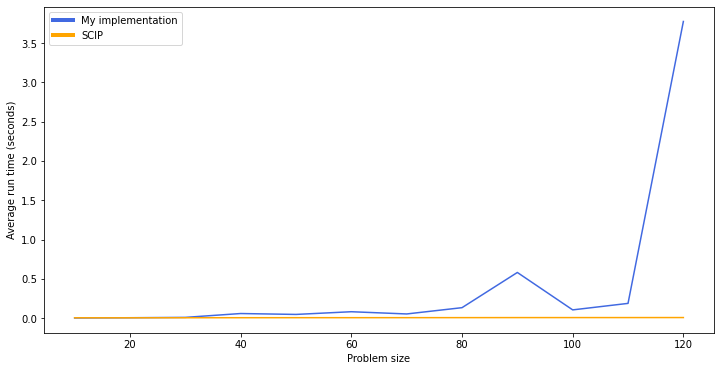

In [35]:
plt.figure(figsize=(12,6))

# My implementation
plt.plot(df[["No_of_items","BB_selbst_time"]].groupby("No_of_items", as_index=False).mean()["No_of_items"],
         df[["No_of_items","BB_selbst_time"]].groupby("No_of_items", as_index=False).mean()["BB_selbst_time"],
         color='royalblue'
        )

# SCIP
plt.plot(df[["No_of_items","SCIP_time"]].groupby("No_of_items", as_index=False).mean()["No_of_items"],
         df[["No_of_items","SCIP_time"]].groupby("No_of_items", as_index=False).mean()["SCIP_time"],
         color='orange'
        )

# Adding a custom legend
custom_lines = [Line2D([0], [0], color='royalblue', lw=4), 
                Line2D([0], [0], color='orange', lw=4)]
plt.legend(custom_lines, ['My implementation', 'SCIP'])

plt.xlabel('Problem size')
plt.ylabel('Average run time (seconds)')
plt.show()

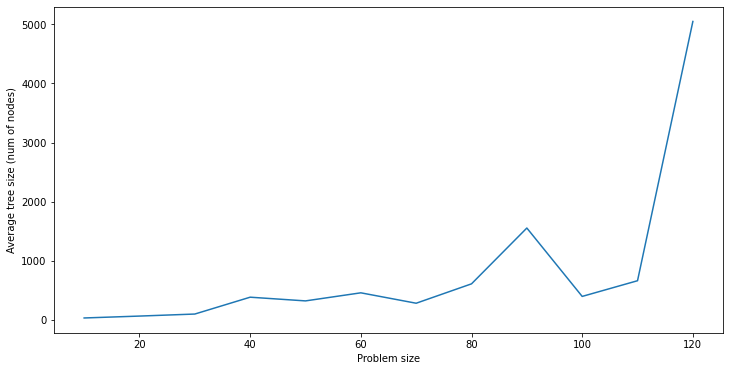

In [36]:
plt.figure(figsize=(12,6))

plt.plot(df[["No_of_items","Tree_size"]].groupby("No_of_items", as_index=False).mean()["No_of_items"],
         df[["No_of_items","Tree_size"]].groupby("No_of_items", as_index=False).mean()["Tree_size"]
        )

plt.xlabel('Problem size')
plt.ylabel('Average tree size (num of nodes)')
plt.show()

In [37]:
df_std = df[["No_of_items", "Tree_size"]].groupby("No_of_items", as_index=False).std()
df_std.rename(columns={"Tree_size":"Tree_size_std"}, inplace=True)
df_mean = df[["No_of_items", "Tree_size"]].groupby("No_of_items", as_index=False).mean()
df_mean.rename(columns={"Tree_size":"Tree_size_mean"}, inplace=True)

df = pd.merge(df, df_std, how='left')
df = pd.merge(df, df_mean, how='left')

def different_obj(row):
    return 0 if row["BB_selbst_obj"] == row["SCIP_obj"] else 1
df["Different_obj"] = df.apply(different_obj, axis=1)

df["Time_per_node"] = df["BB_selbst_time"] / df["Tree_size"]

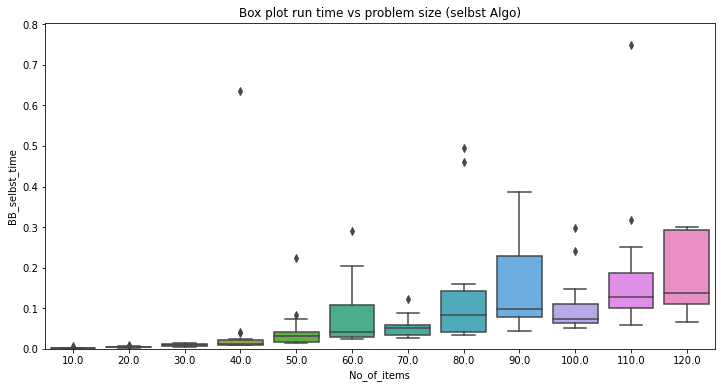

In [47]:
plt.figure(figsize=(12,6))
ax = plt.gca()

plt.title("Box plot run time vs problem size (selbst Algo)")
sns.boxplot(data=df, x="No_of_items", y="BB_selbst_time")
ax.set_ylim([0, df["BB_selbst_time"].mean()+(0.10*df["BB_selbst_time"].std())])
plt.show()

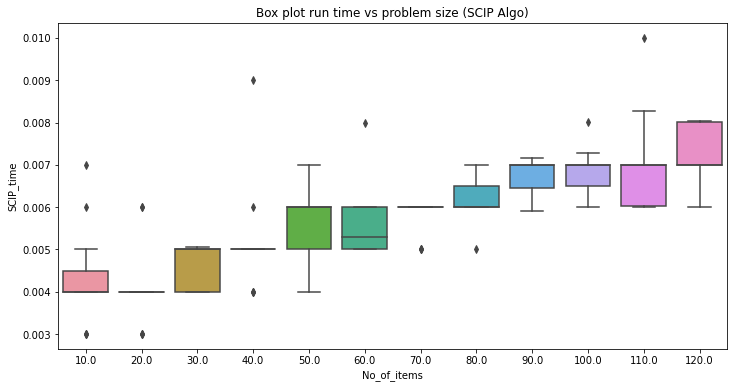

In [48]:
plt.figure(figsize=(12,6))
ax = plt.gca()

plt.title("Box plot run time vs problem size (SCIP Algo)")
sns.boxplot(data=df, x="No_of_items", y="SCIP_time")
#ax.set_ylim([0, df["SCIP_time"].mean()+(0.10*df["SCIP_time"].std())])
plt.show()

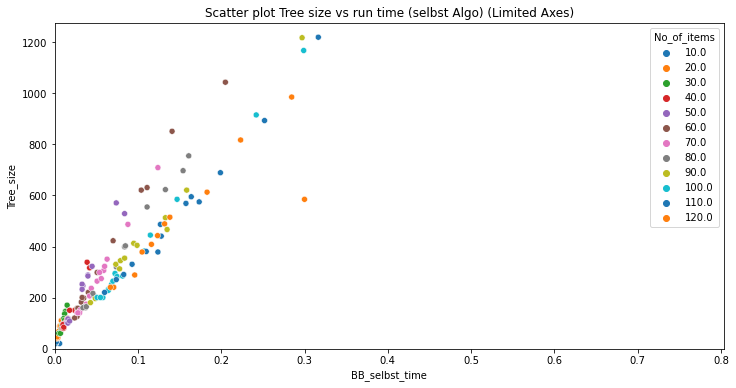

In [49]:
plt.figure(figsize=(12,6))
ax = plt.gca()

plt.title("Scatter plot Tree size vs run time (selbst Algo) (Limited Axes)")
sns.scatterplot(data=df, x="BB_selbst_time", y="Tree_size", hue="No_of_items", palette="tab10")
ax.set_xlim([0,df["BB_selbst_time"].mean()+(0.10*df["BB_selbst_time"].std())])
ax.set_ylim([0,df["Tree_size"].mean()+(0.10*df["Tree_size"].std())])
plt.show()

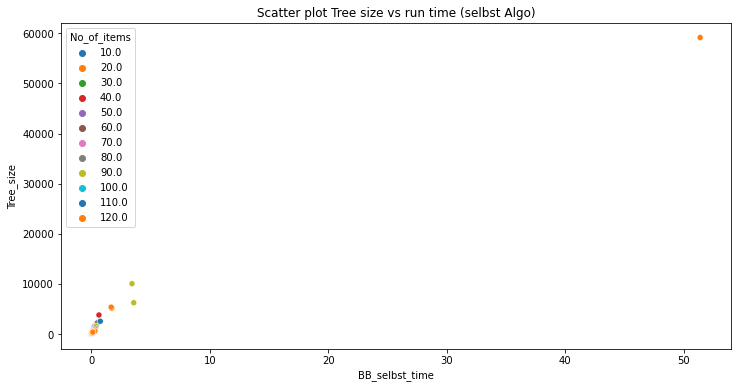

In [50]:
plt.figure(figsize=(12,6))
ax = plt.gca()

plt.title("Scatter plot Tree size vs run time (selbst Algo)")
sns.scatterplot(data=df, x="BB_selbst_time", y="Tree_size", hue="No_of_items", palette="tab10")
plt.show()

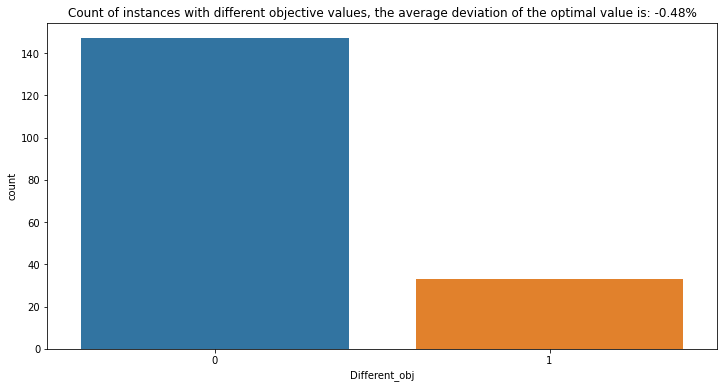

In [51]:
plt.figure(figsize=(12,6))
sns.countplot(data=df, x="Different_obj")

mean_dev_selbst_vs_scip = ((df[df["Different_obj"]==1]["BB_selbst_obj"] - df[df["Different_obj"]==1]["SCIP_obj"]) / df[df["Different_obj"]==1]["BB_selbst_obj"]).mean()
plot_label = "Count of instances with different objective values, the average deviation of the optimal value is: " + "{:.2%}".format(mean_dev_selbst_vs_scip)

plt.title(label=plot_label)
plt.show()

- Unluckily, my implementation yields some results that are different for those that the solver SCIP gives, suggesting that some error has to be fixed
- For problem sizes bigger than ~130 nodes the implementation starts to struggle
- Due to lack of time I could not further dig on the above mentioned errors